In [1]:
# !pip install gym-super-mario-bros==7.3.0

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

import matplotlib.pyplot as plt

c:\Users\Junhong Chen\Documents\GitHub\deep_rl_exercise\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Junhong Chen\Documents\GitHub\deep_rl_exercise\.venv\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


c:\Users\Junhong Chen\Documents\GitHub\deep_rl_exercise\.venv\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(


(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


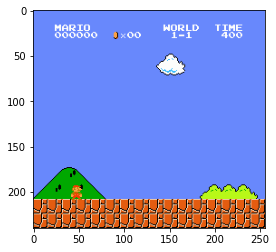

In [2]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")
plt.imshow(next_state)

In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        #bilinear resize
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

(4, 84, 84),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


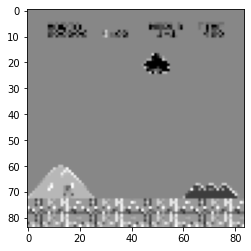

In [4]:
env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")
plt.imshow(next_state[0], cmap="Greys")

In [ ]:
def MCTS (s,net,env):
    

In [9]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        self.net = MarioNet(self.state_dim, self.action_dim).float()

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = exploration_rate_decay
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = save_every  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__() #from lazy frame to array
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

In [10]:
#agent's memory
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Each time Mario performs an action, he stores the experience to his memory. 
        His experience includes the current state, action performed, reward from the action, the next state, and whether the game is done.
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        # *batch: unpact batch to individual (s,s',a,r,d)
        # zip(): create an iteracble on unpacked batch
        # map(): apply torch.stack in each iterable
        # torch.stack: Concatenates a sequence of tensors along a new dimension.
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        # squeeze(): dimension 1 is removed
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [11]:
#DDQN: two ConvNets - online & target, that independently approximate the optimal action-value function.
#Both share the same nn struc but seperate (w,b)
#target does not back propagate to update (w,b). Periodically sync with online
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

In [12]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        
        current_state_Q = self.net(state, model="online")#Q for (batch,action_space)
        current_Q = current_state_Q[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        
        return current_Q

    @torch.no_grad() #don’t need to backpropagate on target (w,b)
    def td_target(self, reward, next_state, done):
        #use online model to find a'
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        #use target model to find q(s',a')
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [13]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every, learn_rate):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learn_rate)
        self.loss_fn = torch.nn.SmoothL1Loss() #mean reduction

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target) #loss between current and target TD
        self.optimizer.zero_grad() #reset grad on each weight to 0, otherwise accumulate on batch
        loss.backward() #compute loss grad wrt weights
        #theta <- theta + lr * Delta(TD_target-q(s,a))
        self.optimizer.step() #adjust weights by grad and learning rate
        return loss.item() #report loss

    def sync_Q_target(self):
        #periodically copy online weights to target model
        self.net.target.load_state_dict(self.net.online.state_dict())

In [14]:
#save checkpoint
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), #exploration rate changing during training
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    def load(self,load_path):
        try:
            self.net.load_state_dict(torch.load(load_path)['model'])
            self.exploration_rate = torch.load(load_path)['exploration_rate']
        except:
            print(
                f"no weights are loaded as either {load_path} cannot be found or incompatible to current model.")
        else:
            print(f"weights are loaded successfuly! exploration_rate is {self.exploration_rate}")

In [15]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every, learn_rate):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every, learn_rate)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory in batch
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate in batch
        td_est = self.td_estimate(state, action)

        # Get TD Target in batch
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

In [16]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

In [17]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir,exploration_rate_decay=0.99999975,save_every=2e5,learn_rate=0.00025)
mario.load("/Users/junhongchen/Documents/GitHub/deep_rl_exercise/pytorch_basic/mario/checkpoints/2022-03-12T00-31-11/mario_net_4.chkpt")

logger = MetricLogger(save_dir)

episodes = 100
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Using CUDA: True

no weights are loaded as either /Users/junhongchen/Documents/GitHub/deep_rl_exercise/pytorch_basic/mario/checkpoints/2022-03-12T00-31-11/mario_net_4.chkpt cannot be found or incompatible to current model.


C:\Users\Junhong Chen\AppData\Local\Temp\ipykernel_23596\3067730520.py:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done]).cuda()


Episode 0 - Step 616 - Epsilon 0.9998460118381219 - Mean Reward 665.0 - Mean Length 616.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.133 - Time 2022-05-07T09:00:23
Episode 20 - Step 4567 - Epsilon 0.9988589014058243 - Mean Reward 620.714 - Mean Length 217.476 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 32.141 - Time 2022-05-07T09:00:55
Episode 40 - Step 7225 - Epsilon 0.9981953800621871 - Mean Reward 605.854 - Mean Length 176.22 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 19.46 - Time 2022-05-07T09:01:15
Episode 60 - Step 10612 - Epsilon 0.9973505157632944 - Mean Reward 601.82 - Mean Length 173.967 - Mean Loss 0.092 - Mean Q Value 0.136 - Time Delta 26.916 - Time 2022-05-07T09:01:42
Episode 80 - Step 14661 - Epsilon 0.9963414583727723 - Mean Reward 619.852 - Mean Length 181.0 - Mean Loss 0.239 - Mean Q Value 0.979 - Time Delta 42.912 - Time 2022-05-07T09:02:25


<Figure size 432x288 with 0 Axes>

In [1]:
from torch import nn

class ResNet(nn.Module):
    def __init__(self, n_filter, n_padding):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels=n_filter, out_channels = n_filter, kernel_size = 3,padding=n_padding),
            nn.BatchNorm2d(n_filter),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_filter, out_channels = n_filter, kernel_size = 3,padding=n_padding),
            nn.BatchNorm2d(n_filter),
          )

    def forward(self, inputs):
        return nn.ReLU()(self.module(inputs) + inputs)

class MuNet(nn.Module):

    def __init__(self, policy_dim, is_reference):
        super().__init__()
        self.policy_dim = policy_dim
        self.is_reference = is_reference
        if is_reference:
          self.body_feature = 256
        else:
          self.body_feature = 256 + self.policy_dim
        
        #INPUT NET
        #Representation - input observation 96x96x(32x(3+1))
        self.rep = nn.Sequential(
          nn.Conv2d(128,128,3,stride=2, padding=1), #48x48x128
          ResNet(128,1),
          ResNet(128,1),
          nn.Conv2d(128,256,3,stride=2, padding=1), #24x24x256
          ResNet(256,1),
          ResNet(256,1),
          ResNet(256,1),
          nn.AvgPool2d(2), #12x12x256
          ResNet(256,1),
          ResNet(256,1),
          ResNet(256,1),
          nn.AvgPool2d(2),#6x6x256 hidden state out
        )
        #Dynamic - input hidden state 6x6x256 and action 6x6xpolicy_dim

        #OUTPUT NET
        self.pol = nn.Sequential(
          nn.Conv2d(in_channels=self.body_feature, out_channels = 1, kernel_size = 1), #2 conv layer
          nn.BatchNorm2d(1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(in_features = 6*6,out_features=self.policy_dim),
        )

        self.val = nn.Sequential(
          
          nn.Conv2d(in_channels=self.body_feature, out_channels = 1, kernel_size = 1), #1 conv layer
          nn.BatchNorm2d(1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(in_features = 6*6,out_features=6),
          nn.ReLU(),
          nn.Linear(in_features =6,out_features=1),
          #tanh
        )

        self.reward = self.val

        #BODY NET
        self.body = nn.Sequential()
        for _ in range(16):
          self.body = nn.Sequential(
            self.body,
            ResNet(self.body_feature,1))

    def forward(self, input):
      if self.is_reference:
        net = nn.Sequential(self.rep,self.body)
        out = net(input)
      return self.pol(out),self.val(out),self.reward(out)

c:\Users\Junhong Chen\Documents\GitHub\deep_rl_exercise\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from torchsummary import summary
m = MuNet(2,is_reference=True).cuda()
summary(m,(128, 96, 96))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]         147,584
            Conv2d-2          [-1, 128, 48, 48]         147,584
       BatchNorm2d-3          [-1, 128, 48, 48]             256
              ReLU-4          [-1, 128, 48, 48]               0
            Conv2d-5          [-1, 128, 48, 48]         147,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
            ResNet-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
       BatchNorm2d-9          [-1, 128, 48, 48]             256
             ReLU-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 128, 48, 48]         147,584
      BatchNorm2d-12          [-1, 128, 48, 48]             256
           ResNet-13          [-1, 128, 48, 48]               0
           Conv2d-14          [-1, 256,